In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [2]:
#Loading MNIST dataset

dataset_path = '~/datasets'
batch_size = 100

#transform the data into tensor
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

#split the dataset into 60000 training and 10000 validation samples
#they are already normalized
train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=True,  **kwargs)

print(len(train_dataset))
print(len(test_dataset))
print(type(train_dataset))

#NOTE: we can use the code of the proffesor for the same results from train_vae.py

60000
10000
<class 'torchvision.datasets.mnist.MNIST'>


In [3]:
#create an Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma).to(DEVICE)
        z = mu + sigma * epsilon
        
        return z

In [4]:
#create an Encoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h))
        return x_reconstr

In [5]:
#create the VAE
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
                
    def forward(self, x):
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        
        return x_reconstr, mu, log_sigma

In [6]:
x_dim  = 784
hidden_dim = 100
latent_dim = 2  #is too low-dimensional to perform well 

cuda = True 
DEVICE = torch.device("cuda" if cuda else "cpu")

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

vae = VAE(encoder=encoder, decoder=decoder).to(DEVICE)

In [7]:
#Elbo loss
lr = 1e-3

def loss_function(x, x_reconstr, mu, log_sigma):
    #     d2 = (mu - x) ** 2
    #     log_p = -0.5 * torch.sum(np.log(x_reconstr * 2 * np.pi) + d2 / x_reconstr)
    #     KL = -0.5 * torch.sum(1 + torch.log(z) - mu**2 - z)
    #     negative_ELBO = -log_p + KL
    #     return negative_ELBO
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

optimizer = Adam(vae.parameters(), lr=lr)

In [8]:
#Training the VAE
epochs = 5

print("Start training VAE...")
vae.train()

elbo = []
best_elbo = 1
elb = 0
es = 0
print(type(elb))
print(type(best_elbo))


for epoch in range(epochs):
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()
   
        x_reconstr, mu, log_sigma = vae(x)
        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        

    n_datapoints = batch_idx * batch_size
    elb = overall_loss / n_datapoints
    elbo.append(elb)

    # initialize the early stopping creterion
    #dummy criterion. Maybe we can use something like if the absolute difference is smaller than...
    if elb > best_elbo:
      best_elbo == elbo 
      es = 0
      torch.save(vae.state_dict(), "model_" + 'weight.pt')
    else:
      es +=1
      print("Counter {} of 5".format(es))

      if es > 4:
          print("Early stopping with best_acc: ", best_elbo, "and val_acc for this epoch: ", elbo, "...")
          break
    
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)
    
print("Training complete!")

Start training VAE...
<class 'int'>
<class 'int'>
	Epoch 1 	Average Loss:  49.233995302228976 	Reconstruction Loss: 48.11855176514894 	KL Loss: 1.115443561180605
	Epoch 2 	Average Loss:  40.23011498249035 	Reconstruction Loss: 38.803273025028695 	KL Loss: 1.4268419211615306
	Epoch 3 	Average Loss:  38.33759565503052 	Reconstruction Loss: 36.61916840160033 	KL Loss: 1.7184272182763916
	Epoch 4 	Average Loss:  37.302937663847295 	Reconstruction Loss: 35.42924117507043 	KL Loss: 1.8736964997305894
	Epoch 5 	Average Loss:  36.653841289845055 	Reconstruction Loss: 34.670059017633555 	KL Loss: 1.983782268899908
Training complete!


In [9]:
#Evaluate the VAE and reconstruct the data
vae.eval()

x_original_list = []
y_list = []
x_reconstr_list = []
mu_list = []
log_sigma_list = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_reconstr, mu, log_sigma = vae(x)
        x_original_list.append(x)
        y_list.append(y)
        x_reconstr_list.append(x_reconstr)
        mu_list.append(mu)
        log_sigma_list.append(log_sigma)

100%|██████████| 100/100 [00:01<00:00, 98.36it/s]


[49.233995302228976, 40.23011498249035, 38.33759565503052, 37.302937663847295, 36.653841289845055]


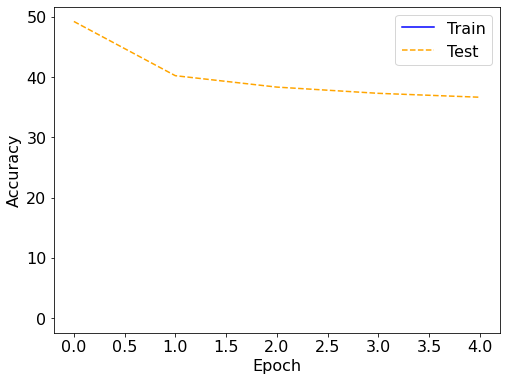

In [10]:
#plotting Loss

'''
To get an overview of the accuracy over the training period, we define a simple function
to plot the saved accuracies.
'''
def plot_train(train, test):
    fig, ax = plt.subplots(figsize=(8,6))
    fnt=16
    ax.plot(train, color='blue', label='Train')
    ax.plot(test, color='orange', linestyle='--', label='Test')
    ax.legend(fontsize=fnt)
    ax.tick_params(axis='both', labelsize=fnt)
    ax.set_xlabel('Epoch', fontsize=fnt)
    ax.set_ylabel('Accuracy', fontsize=fnt)

plot_train(0, elbo)
print(elbo)

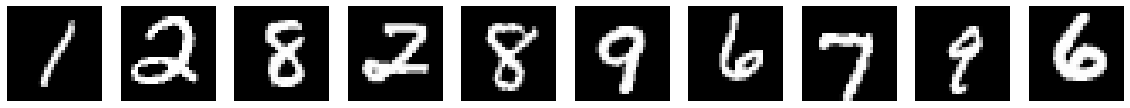

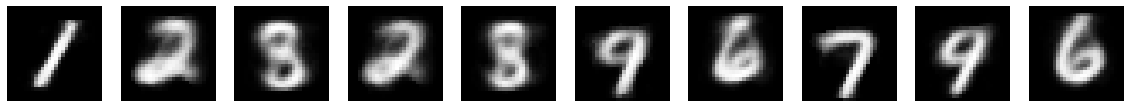

In [11]:
#Plotting the reconstructions
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy(), cmap="Greys_r")
def show_images(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(batch_size, 28, 28)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys_r")
        ax[idx].axis('off')
batch_idx = 0
show_images(x_original_list[batch_idx])
show_images(x_reconstr_list[batch_idx])